# Finding suitable spots for placing heart defibrillator equipments in public
In this sample, we will observe how site [suitability analyses](https://en.wikipedia.org/wiki/Suitability_analysis) can be performed using the ArcGIS API for Python. The objective of this sample is to find locations in the city of Philadelphia that are suitable for placing [AED (Automated External Defibrillator)](https://en.wikipedia.org/wiki/Automated_external_defibrillator) for public emergencies.

The criteria for a suitable place are those that have high incidence of [OHCA (Out of Hospital Cardiac Arrests)](http://www.sca-aware.org/sca-news/aha-releases-latest-statistics-on-out-of-hospital-cardiac-arrest) and be accessible to public, such as commercial areas.

As inputs, we start with geocoded OCHA (Out-of-Hospital Cardiac Arrest) point data, along with a few base layers for the city of Pittsburgh published as feature layers. As output, we need to generate a list of locations that have a high incidence of heart-attacks and located within commercial areas, allowing easy access at times of emergencies.

#### Connect to the GIS

In [10]:
from arcgis.gis import *
gis = GIS("https://python.playground.esri.com/portal","arcgis_python","amazing_arcgis_123")

### Preview the input datasets

<Item title:"Pittsburgh_heart_attacks" type:Feature Layer Collection owner:arcgis_python>
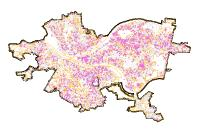

In [2]:
ohca_item = gis.content.search("Pittsburgh_heart_attacks", "Feature Layer")[0]
ohca_item

In [97]:
map1 = gis.map("Pittsburgh, PA", zoomlevel=12)
map1

In [98]:
map1.add_layer(ohca_item)

Let us take a look at the layers available in this item

In [3]:
for lyr in ohca_item.layers:
    print(lyr.properties.name)

Heart attack incidence
Streets
Zoning
Rivers
Pittsburgh boundary


### Outline of the analysis
For the rest of this analysis, we will use the `Zoning` polygon layer and build a `600`-foot buffers around it to represent areas that are accessible to commercial zones. Next, we will use the `Heart attack incidence` point layer to build a density raster. This raster depicts those areas that have a higher incidence of cardiac arrests. Finally, we will overlay the buffers on the density raster to pick places that are suitable to place new AED devices.

## Create a 600 feet buffer around commercial areas
The `Zoning` feature layer contains polygon features that represent different zones such as commercial, residential etc. We need to select those features that correspond to commercial zones and create a buffer of `600` feet around them. The `600` feet area roughly corresponds to two-blocks, a walk able distance in case of an emergency.

### Select commercial zones
To select the commercial zones using a query, we need to know what columns and values are available. Hence, let us construct a small query that gives the first few rows / features.

In [3]:
zoning_flayer = ohca_item.layers[2]
zoning_fset = zoning_flayer.query(result_record_count=10, return_all_records=False)

In [4]:
zoning_fset.df

,acres,area,code,code_2,name,objectid,perimeter,sqmiles,symbol,x,y,zon_new,zoning_,zoning_grouped,zoning_id,SHAPE
0,370.108,1.591398e+07,R1D-L,R1D-L,Single-Unit Detached Residential/Low Density,1,52563.176,0.576,80,1.340082e+06,429618.202356,R1D-L,2,Residential,5521,"{'rings': [[[-80.01772016299998, 40.4977767210..."
1,370.108,8.107219e+04,R2-L,R2-L,Two-Unit Residential/Low Density,2,1524.910,0.576,80,1.338226e+06,432380.904671,R2-L,3,Non Commercial,5522,"{'rings': [[[-80.01757926499994, 40.4981592720..."
2,60.461,2.591469e+06,R2-L,R2-L,Two-Unit Residential/Low Density,3,14071.084,0.094,83,1.335954e+06,430498.618340,R2-L,4,Non Commercial,5526,"{'rings': [[[-80.02201914599993, 40.4938213470..."
3,19.306,8.370962e+05,RP,RP,Residential Planned Unit Development,4,5395.625,0.030,85,1.340037e+06,431409.546743,RP,5,Residential,5517,"{'rings': [[[-80.01117829099985, 40.4967724760..."
4,0.223,9.650762e+03,RM-M,RM-M,Multi-Unit Residential/Low Density,5,441.323,0.000,84,1.339642e+06,431798.332613,RM-M,6,Residential,5519,"{'rings': [[[-80.01130567899997, 40.4967769370..."
5,0.682,2.956994e+04,RM-M,RM-M,Multi-Unit Residential/Low Density,6,694.941,0.001,84,1.339795e+06,431772.596200,RM-M,7,Residential,5518,"{'rings': [[[-80.01056552699987, 40.4966935830..."
6,370.108,1.301243e+05,R2-L,R2-L,Two-Unit Residential/Low Density,7,1882.449,0.576,80,1.337204e+06,431420.364326,R2-L,8,Non Commercial,5523,"{'rings': [[[-80.02005998699991, 40.4963623440..."
7,14.709,6.377810e+05,PO,PO,Parks and Open Space,8,4160.470,0.023,73,1.337574e+06,430975.826537,PO,9,Non Commercial,5524,"{'rings': [[[-80.01961748999992, 40.4955720630..."
8,4.975,2.080350e+05,UI,UI,Urban Industrial District,9,2329.875,0.008,128,1.341530e+06,431299.784705,UI,10,Commercial,5520,"{'rings': [[[-80.00390870399991, 40.4945575660..."
9,60.461,2.625691e+07,PO,PO,Parks and Open Space,10,67658.258,0.094,83,1.336595e+06,425033.974710,PO,11,Non Commercial,5537,"{'rings': [[[-80.02087123699982, 40.4914294070..."


The column `zoning_grouped` contains zoning categories. We are intersted in those polygons that correspond to the `Commercial` category.

In [5]:
zoning_commercial_fset = zoning_flayer.query("zoning_grouped = 'Commercial'")
commercial_zone_df = zoning_commercial_fset.df
commercial_zone_df.head(5)[['name','zoning_grouped']] #display the first 5 results

,name,zoning_grouped
0,Urban Industrial District,Commercial
1,Local Neighborhood Commercial,Commercial
2,Neighborhood Industrial,Commercial
3,Local Neighborhood Commercial,Commercial
4,General Industrial,Commercial


In [6]:
commercial_zone_df.shape

(317, 16)

Let us draw the selected polygons on a map

In [24]:
zone_map = gis.map("Pittsburgh, PA")
zone_map

In [25]:
zone_map.draw(zoning_commercial_fset)

Thus, from `965` zoning polygons, we have narrowed down to `317`.

### Create buffers on in-memory FeatureCollection

The ArcGIS API for Python allows you to perform analysis on in-memory objects, meaning, you do not have to create feature layers for intermediate results, such as for the output of the previous feature selection. To execute the `create_buffers` tool, create an in-memory `FeatureCollection` object using these selected features.

In [7]:
from arcgis.features import FeatureCollection
zoning_commercial_fc = FeatureCollection(zoning_commercial_fset.to_dict())

In [8]:
from arcgis.features import use_proximity

Use the `zoning_commercial_fc` as an input for the buffer tool

In [10]:
commercial_buffers = use_proximity.create_buffers(zoning_commercial_fc, 
                                                  distances=[600],units='Feet', 
                                                  dissolve_type='Dissolve',
                                                 output_name='commercial_buffers')

Draw the results on the `commercial_zone_map` created above

In [26]:
zone_map.add_layer(commercial_buffers)

### Create a density map to find areas of high heart attack incidence
To calculate the density, we use `calculate_density` tool available under the `raster` module and provide the `Heart attack incidence` feature layer as its input. This layer has a column named `num_incidence` that additionally specifies the number of heart attacks that happened at each point location. Below we bring up a few of the features to get an idea.

In [9]:
ha_incidence = ohca_item.layers[0] #the first layer in the input feature layer collection
ha_incidence_fset = ha_incidence.query(result_record_count=10, return_all_records=False)
ha_incidence_fset.df.head(10)

,fid_1,id,no,num_incidence,objectid_1,pop2000,yes,SHAPE
0,0,1,1,0,1,0,0,"{'x': -79.97274830899988, 'y': 40.437756305000..."
1,8,9,1,0,2,96,0,"{'x': -79.97639852099996, 'y': 40.43720295300017}"
2,12,13,1,0,3,5,0,"{'x': -79.98023401899997, 'y': 40.43833489900004}"
3,13,14,1,0,4,3,0,"{'x': -79.9818761219999, 'y': 40.43839959000019}"
4,25,26,1,0,5,15,0,"{'x': -79.98428402499985, 'y': 40.437456611000..."
5,28,29,1,0,6,8,0,"{'x': -79.98319929899998, 'y': 40.43677839000014}"
6,30,31,1,0,7,42,0,"{'x': -79.98183133499987, 'y': 40.437055132000..."
7,51,52,4,0,8,0,0,"{'x': -79.98873209699991, 'y': 40.43516450700008}"
8,70,71,2,0,9,0,0,"{'x': -79.98717537399989, 'y': 40.437418760000..."
9,72,73,1,0,10,536,0,"{'x': -79.9918783149999, 'y': 40.4381269750001}"


#### Calculate density

In [15]:
from arcgis.raster.analytics import calculate_density
from arcgis.raster.functions import *

In [12]:
ha_density = calculate_density(ha_incidence, count_field='num_incidence', 
                               output_cell_size={'distance':150,'units':'feet'},
                               output_name = 'ha_density')
ha_density

<Item title:"ha_density" type:Imagery Layer owner:arcgis_python>

Let us display the density raster on a map

In [15]:
density_map = gis.map("Pittsburgh, PA", zoomlevel=11)
density_map

Use the `stretch` [raster function](http://pro.arcgis.com/en/pro-app/help/data/imagery/stretch-function.htm) to enhance the density layer before adding it to the map:

In [16]:
density_layer = ha_density.layers[0]

stretch_rf = stretch(density_layer, stretch_type='StdDev',num_stddev=2)
colormap_rf = colormap(stretch_rf, colormap_name='Gray')

In [17]:
density_map.add_layer(colormap_rf, {"opacity":0.5})

From the `density_map`, we see certain regions (in shades of white) have a higher density of heart attack incidences compared to the rest.

## Reclassify the density raster
Calculate density tool returns the number of incidences per sq.mile. We are interested in the number of heart attacks at a larger scale of about 5 square blocks. In Pittsburgh, each block spans about 300 ft in length, thus 5 sq. blocks cover an area of 1500 x 1500 sq.feet. We apply `remap` raster function to convert the density from sq. miles to that in 5 block area

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Plot the histogram to view actual density values and its distribution. The `histograms` property of the `ImageryLayer` object returns you histogram of each of its bands.

In [9]:
density_hist = density_layer.histograms

Construct the X axis such that it ranges from min value to max value of the pixel range in the image.

In [10]:
x = np.linspace(density_hist[0]['min'], density_hist[0]['max'], num=density_hist[0]['size'])

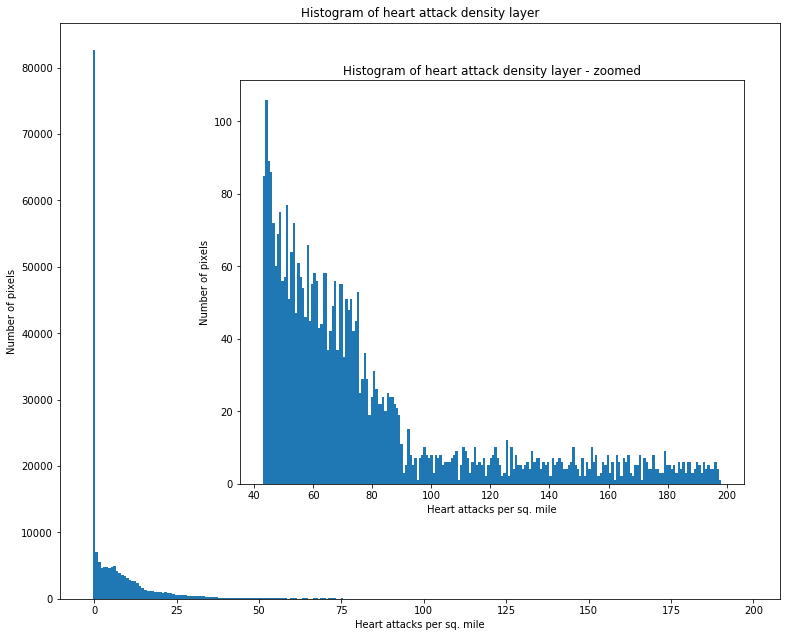

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(x,density_hist[0]['counts'])
ax.set_title("Histogram of heart attack density layer")
ax.set_xlabel("Heart attacks per sq. mile")
ax.set_ylabel("Number of pixels")

ax2 = fig.add_axes([0.25,0.2,0.7,0.7])
ax2.bar(x[-200:], density_hist[0]['counts'][-200:])
ax2.set_title("Histogram of heart attack density layer - zoomed")
ax2.set_xlabel("Heart attacks per sq. mile")
ax2.set_ylabel("Number of pixels")

The inset histogram chart has the histogram zoomed to view the distribution in the upper end of the density spectrum. We are interested in selecting those regions that have a heart attack of at least 5 per 5 block area. To achieve this, we need to convert the density from square miles to 5 square blocks.

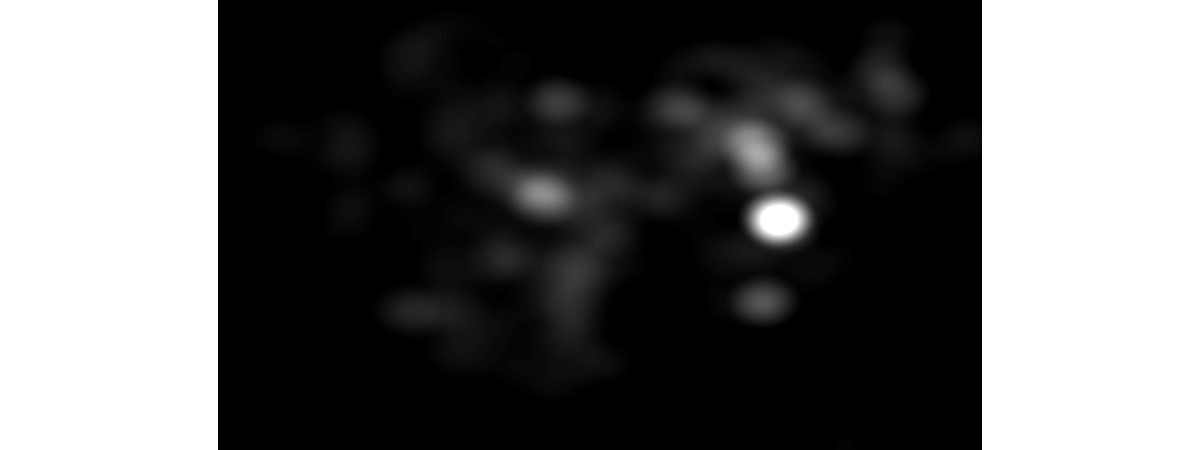

In [8]:
conversion_value = (1500*1500)/(5280*5280)
density_5blocks = density_layer * conversion_value #raster arithmetic
density_5blocks

Let us remap this continuous density raster to a binary layer representing whether a pixel represents high enough density or not.

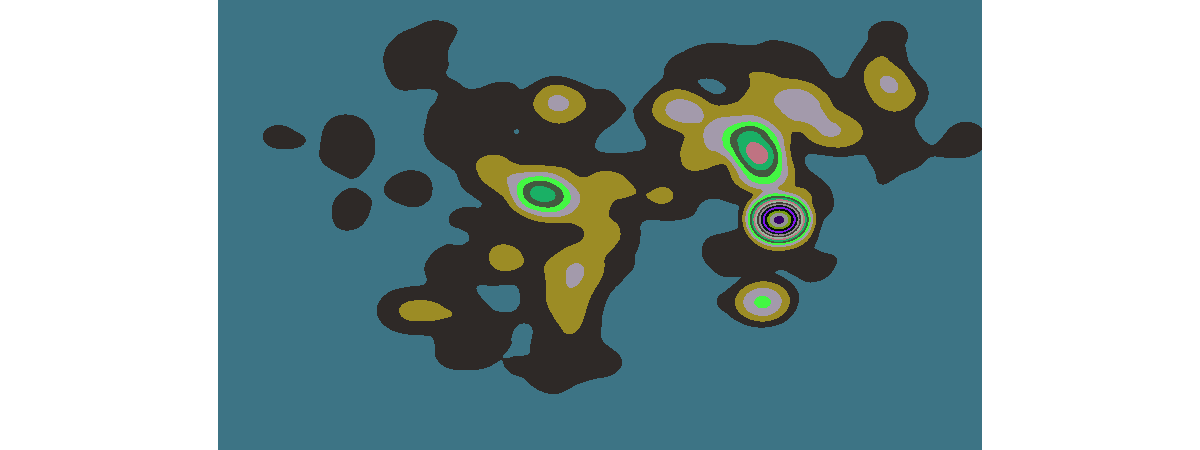

In [9]:
density_classified_color = colormap(density_5blocks, colormap_name='Random',astype='u8')
density_classified_color

Next, we classify the density raster such that pixels that have heart attacks greater than 5 get value 1 and rest become 'no data' pixels.

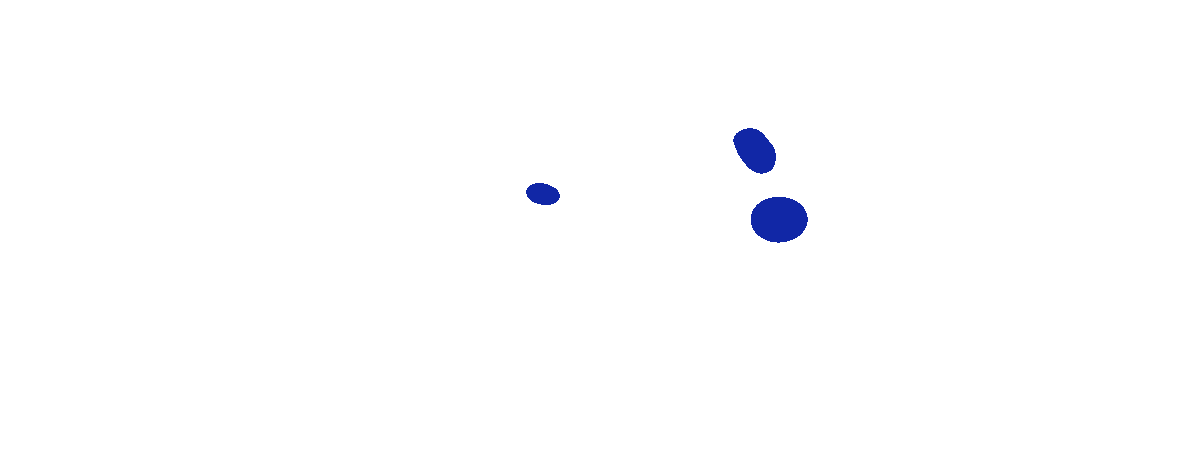

In [19]:
#remap pixel values to create a binary raster
density_classified = remap(density_5blocks, input_ranges=[5,16], output_values=[1],astype='u8',no_data_ranges=[0,5])
density_classified_viz = colormap(density_classified, colormap_name='Random', astype='u8')
density_classified_viz

Through classification, we have determined there are 3 hotspots in our density raster. Let us overlay this on a map to see which areas these hotspots correspond to.

In [20]:
density_map2 = gis.map("Pittsburgh, PA")
density_map2

In [21]:
density_map2.add_layer(density_classified_viz)

## Perform overlay analysis

The site selection condition requires two inputs, the heart attack density layer (which we created earlier) and the accessibility layer (from the buffer analysis). To perform overlay, we need to convert the buffers layer to a raster layer of matching cell size as that of the density raster layer. To perform this conversion we use the `convert_feature_to_raster` method.

In [18]:
from arcgis.raster import convert_feature_to_raster

In [ ]:
buffer_raster = convert_feature_to_raster(commercial_buffers.layers[0],
                                          output_cell_size={'distance':150, 'units':'feet'},
                                          output_name='buffer_raster')

Query the layer to quickly visualize it as an image

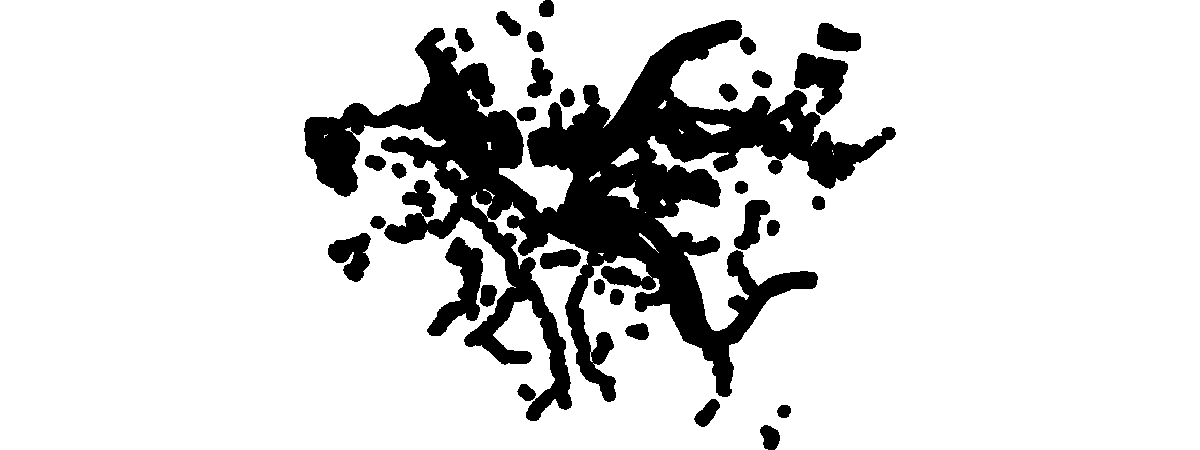

In [5]:
buffer_raster

The `raster` module of the Python API provides numerous raster functions. Of which we use the [bitwise_and](http://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/local-function.htm) local function which returns an image with pixels that match in both the input rasters.

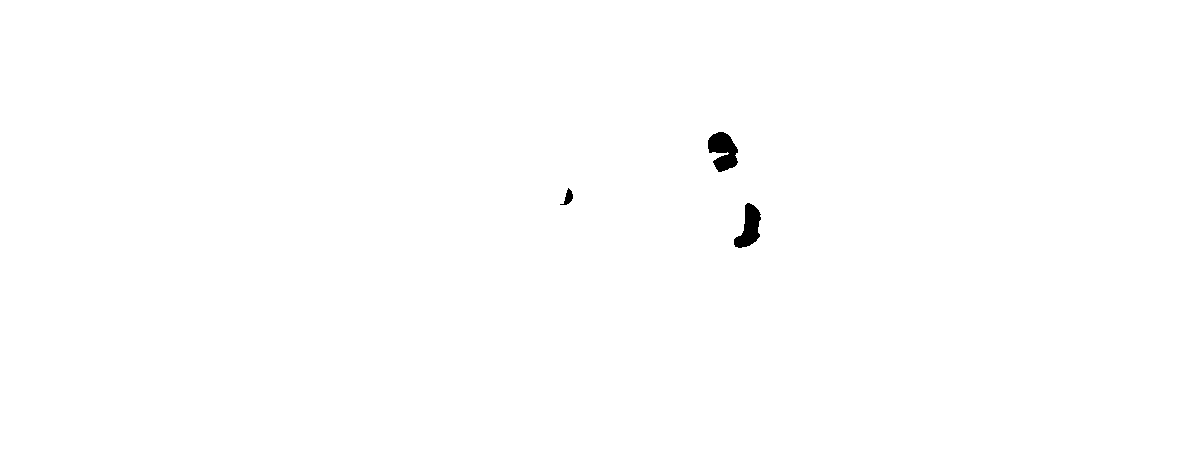

In [23]:
bool_overlay = bitwise_and([buffer_raster,density_classified])
bool_overlay

Let us overlay this final result on a map to visualize the regions that are suitable to locating new AED devices.

In [24]:
map3 = gis.map("Carnegie Mellon University, PA")
map3

## Conclusion
Thus, in this sample, we observed how site-suitability analyses can be performed using ArcGIS and the ArcGIS API for Python. We started with the requirements for placing new AED devices as -- high intensity of cardiac arrests and proximity to commercial areas. Using a combination of in-memory feature analysis and raster analysis, we were able to process and extract the suitable sites. The analyst could convert the results from raster to vector, perform a centroid operation on the polygons, followed by reverse geocode to get the addresses of these 3 suitable locations for reporting and further action.